**Business need and modeling objective**

TikTok users can report videos that they believe violate the platform's terms of service. Because there are millions of TikTok videos created and viewed every day, this means that many videos get reported&mdash;too many to be individually reviewed by a human moderator.

TikTok wants to build a machine learning model to help identify claims and opinions. Videos that are labeled opinions will be less likely to go on to be reviewed by a human moderator. Videos that are labeled as claims will be further sorted by a downstream process to determine whether they should get prioritized for review. For example, perhaps videos that are classified as claims would then be ranked by how many times they were reported, then the top x% would be reviewed by a human each day.

You are a data professional at TikTok. The data team is working towards building a machine learning model that can be used to determine whether a video contains a claim or whether it offers an opinion. With a successful prediction model, TikTok can reduce the backlog of user reports and prioritize them more efficiently and help to mitigate misinformation in videos on the TikTok platform.

Preliminary steps to do before building the machine learning model is to:

1) To investigate and understand the data

2) Do EDA with the aim of learning more about the variables. Of particular interest is information related to what distinguishes claim videos from opinion videos.

Other steps include Hypoethesis testing and Regression modelling if needed.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import packages for statistical analysis/hypothesis testing
from scipy import stats

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [ ]:
data = pd.read_csv("tiktok_dataset.csv")

In [ ]:
data.head(10)

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0
5,6,claim,8972200955,35,someone shared with me that gross domestic pro...,not verified,under review,336647.0,175546.0,62303.0,4293.0,1857.0
6,7,claim,4958886992,16,someone shared with me that elvis presley has ...,not verified,active,750345.0,486192.0,193911.0,8616.0,5446.0
7,8,claim,2270982263,41,someone shared with me that the best selling s...,not verified,active,547532.0,1072.0,50.0,22.0,11.0
8,9,claim,5235769692,50,someone shared with me that about half of the ...,not verified,active,24819.0,10160.0,1050.0,53.0,27.0
9,10,claim,4660861094,45,someone shared with me that it would take a 50...,verified,active,931587.0,171051.0,67739.0,4104.0,2540.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [ ]:
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [ ]:
# Check for missing values
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [ ]:
data = data.dropna(axis=0)

In [ ]:
data.duplicated().sum()

0

video counts by  claim status.

In [ ]:
data['claim_status'].value_counts(normalize=True)

claim      0.503458
opinion    0.496542
Name: claim_status, dtype: float64

Examining the engagement trends associated with each different claim status.

In [ ]:
# What is the average view count of videos with "claim" status?
mask = data['claim_status'] == 'claim'
print('Avg view count:', data[mask].mean()['video_view_count'])
print('Median view count:', data[mask].median()['video_view_count'])

Avg view count: 501029.4527477102
Median view count: 501555.0


C:\Users\clyve\AppData\Local\Temp\ipykernel_41368\4210960772.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print('Avg view count:', data[mask].mean()['video_view_count'])
C:\Users\clyve\AppData\Local\Temp\ipykernel_41368\4210960772.py:4: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print('Median view count:', data[mask].median()['video_view_count'])


In [ ]:
# What is the average view count of videos with "opinion" status?
mask = data['claim_status'] == 'opinion'
print('Avg view count:', data[mask].mean()['video_view_count'])
print('Median view count:', data[mask].median()['video_view_count'])

Avg view count: 4956.43224989447
Median view count: 4953.0


C:\Users\clyve\AppData\Local\Temp\ipykernel_41368\2731743925.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print('Avg view count:', data[mask].mean()['video_view_count'])
C:\Users\clyve\AppData\Local\Temp\ipykernel_41368\2731743925.py:4: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print('Median view count:', data[mask].median()['video_view_count'])


Average view counts for videos labled as ckaims are much higher than those labelled as opinions. Preference for claim videos mmay have several reasons.

In [ ]:
# Get counts for each group combination of claim status and author ban status
data.groupby(['claim_status','author_ban_status']).count()[['#']]

#
claim_status author_ban_status      
claim        active             6566
             banned             1439
             under review       1603
opinion      active             8817
             banned              196
             under review        463

Banned authors have a higher count of 'claim' videos. Authors are falsely labelling their videos as 'claim'. 

In [ ]:
# What's the median video share count of each author ban status?
data.groupby(['author_ban_status']).median()[['video_share_count']]

C:\Users\clyve\AppData\Local\Temp\ipykernel_41368\3899673031.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby(['author_ban_status']).median()[['video_share_count']]


,video_share_count
author_ban_status,
active,437.0
banned,14468.0
under review,9444.0


**Question:** What do you notice about the share count of banned authors, compared to that of active authors? Explore this in more depth.


In [ ]:
data.groupby(['author_ban_status']).agg({'video_view_count':['mean','median'],
                                         'video_like_count':['mean', 'median'],
                                         'video_share_count':['mean', 'median']})

video_view_count           video_like_count            \
                              mean    median             mean    median   
author_ban_status                                                         
active               215927.039524    8616.0     71036.533836    2222.0   
banned               445845.439144  448201.0    153017.236697  105573.0   
under review         392204.836399  365245.5    128718.050339   71204.5   

                  video_share_count           
                               mean   median  
author_ban_status                             
active                 14111.466164    437.0  
banned                 29998.942508  14468.0  
under review           25774.696999   9444.0

Share count of banned authors much higher than those of active authors. The mean is much larger than the median, which indicates that there are some videos with very high engagement counts

In [ ]:
# Create a likes_per_view column
data['likes_per_view'] = data['video_like_count'] / data['video_view_count']
# Create a comments_per_view column
data['comments_per_view'] = data['video_comment_count'] / data['video_view_count']
# Create a shares_per_view column
data['shares_per_view'] = data['video_share_count'] / data['video_view_count']

How does the data for claim videos and opinion videos compare or differ? Consider views, comments, likes, and shares.

In [ ]:
data.groupby(['claim_status', 'author_ban_status']).agg(
    {'likes_per_view': ['count', 'mean', 'median'],
     'comments_per_view': ['count', 'mean', 'median'],
     'shares_per_view': ['count', 'mean', 'median']})

likes_per_view                      \
                                        count      mean    median   
claim_status author_ban_status                                      
claim        active                      6566  0.329542  0.326538   
             banned                      1439  0.345071  0.358909   
             under review                1603  0.327997  0.320867   
opinion      active                      8817  0.219744  0.218330   
             banned                       196  0.206868  0.198483   
             under review                 463  0.226394  0.228051   

                               comments_per_view                      \
                                           count      mean    median   
claim_status author_ban_status                                         
claim        active                         6566  0.001393  0.000776   
             banned                         1439  0.001377  0.000746   
             under review                   1603  0.001367  0.000789   
opinion      active                         8817  0.000517  0.000252   
             banned                          196  0.000434  0.000193   
             under review                    463  0.000536  0.000293   

                               shares_per_view                      
                                         count      mean    median  
claim_status author_ban_status                                      
claim        active                       6566  0.065456  0.049279  
             banned                       1439  0.067893  0.051606  
             under review                 1603  0.065733  0.049967  
opinion      active                       8817  0.043729  0.032405  
             banned                        196  0.040531  0.030728  
             under review                  463  0.044472  0.035027

### Summary

The data is evenly balanced with nearly equal number of claims and opinions. Factors that correlate to claim status include author_ban_status, video_view_count, videoo_like_count, video_share_count.

videos by banned authors and those under review tend to get higher view, like and share counts than non-banned authors. However, when a video is viewed, it is more related to the claim status. 

claim videos have higher view rate than opinion videos, which means they will have higher likes on average, so they are received more favourably.They also receive more engagement through comments and shares than opinion videos.

for claim videos, banned authors have slightly higher view/likes and share/view rates than active authors and those under review. For opinion videos, banned authors have lower like/view, comments/view, and share/view rate compared to active and under review authors.

# EDA

perform further EDA on this data with the aim of learning more about the variables. Of particular interest is information related to what distinguishes claim videos from opinion videos.

#### **video_duration_sec**

<Axes: xlabel='video_duration_sec'>

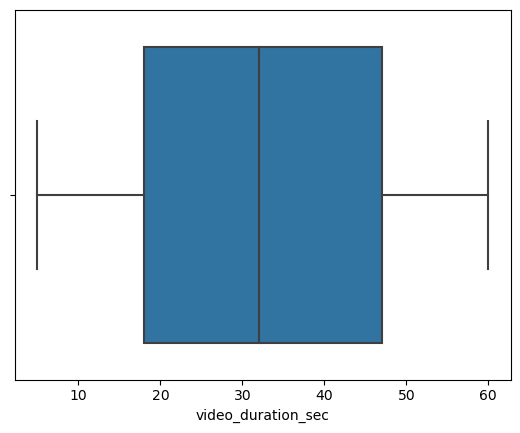

In [ ]:
# Create a boxplot to visualize distribution of `video_duration_sec`
sns.boxplot(x='video_duration_sec', data = data )

<Axes: xlabel='video_duration_sec', ylabel='Count'>

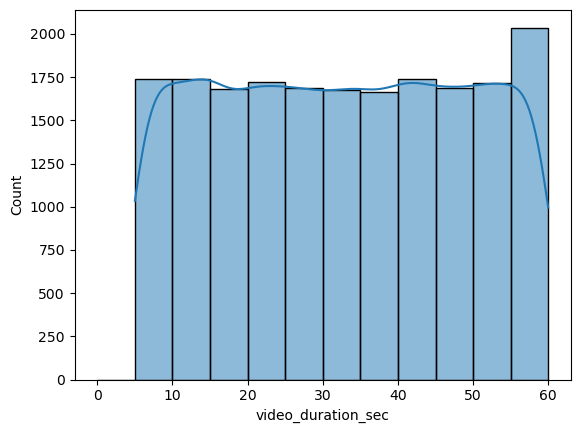

In [ ]:
# Create a histogram
sns.histplot(data=data, x='video_duration_sec', kde=True, bins=range(0,61,5))

Duration of videos range from 5 to 60 seconds. the videos from 5 to 50 sec are uniformly distributed while videos lasting 60 seconds is slightly higher.



#### **video_view_count**


<Axes: xlabel='video_view_count'>

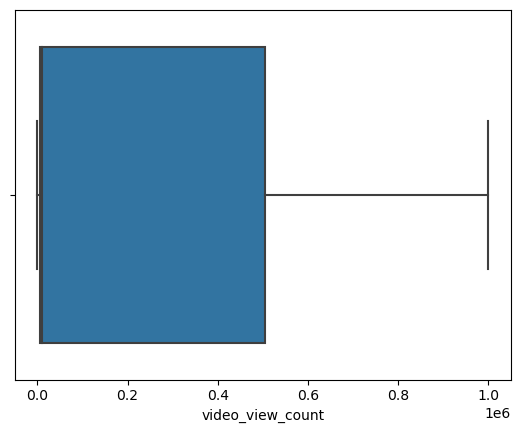

In [ ]:
# Create a boxplot to visualize distribution of `video_view_count`
sns.boxplot(x='video_view_count', data = data )

<Axes: xlabel='video_view_count', ylabel='Count'>

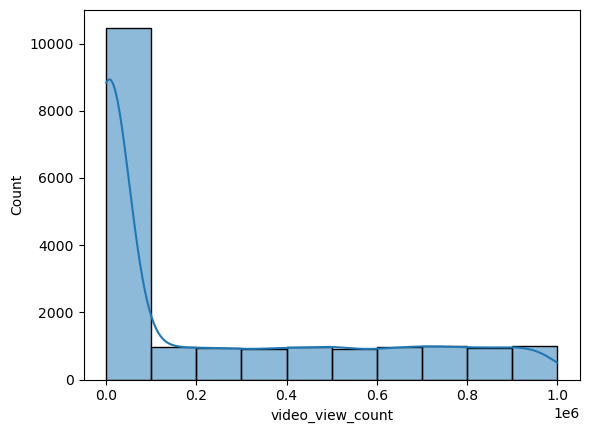

In [ ]:
# Create a histogram
sns.histplot(data=data, x='video_view_count', kde=True, bins=range(0,(10**6+1),10**5))

 This variable has a very uneven distribution, with more than half the videos receiving fewer than 100,000 views. Distribution of view counts > 100,000 views is uniform.


#### **video_like_count**

<Axes: xlabel='video_like_count'>

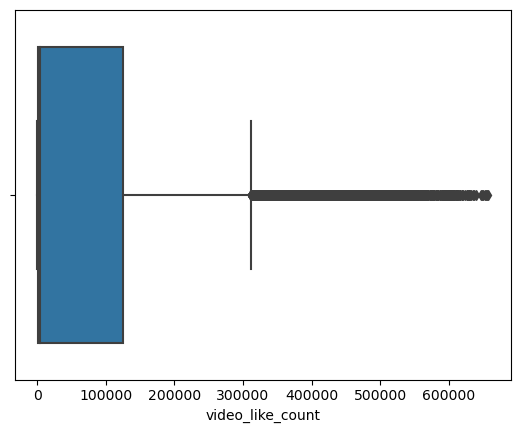

In [ ]:
# Create a boxplot to visualize distribution of `video_like_count`
### YOUR CODE HERE ###
sns.boxplot(x='video_like_count', data = data )

Create a histogram of the values in the `video_like_count` column to further explore the distribution of this variable.

<Axes: xlabel='video_like_count', ylabel='Count'>

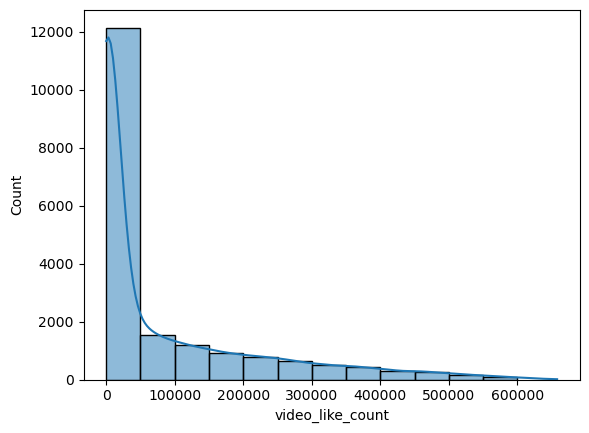

In [ ]:
sns.histplot(data=data, x='video_like_count', kde=True, bins=range(0,600001,50000))

Similar to view count, there are far more videos with < 100,000 likes than there are videos with more. 

#### **video_comment_count**

<Axes: xlabel='video_comment_count'>

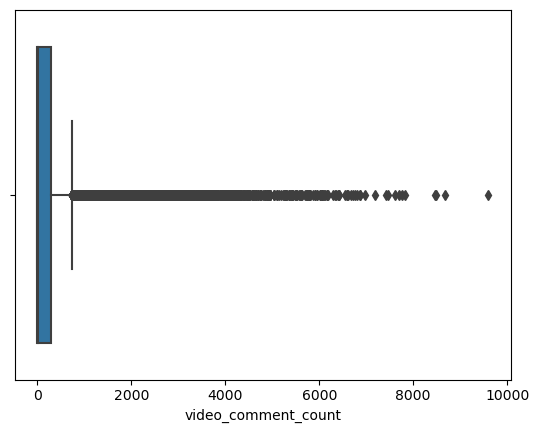

In [ ]:

sns.boxplot(x='video_comment_count', data = data )

<Axes: xlabel='video_comment_count', ylabel='Count'>

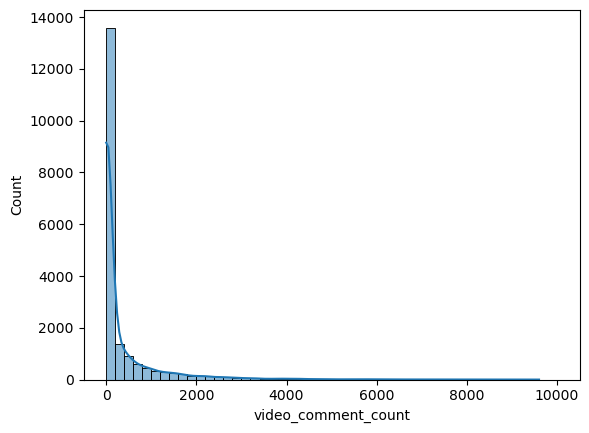

In [ ]:
sns.histplot(data=data, x='video_comment_count', kde=True, bins=range(0,10001,200))

Distribution is very right-skewed where most videos are grouped at the bottom of the range of values. Most videos have fewer than 100 comments.

#### **video_share_count**

<Axes: xlabel='video_share_count'>

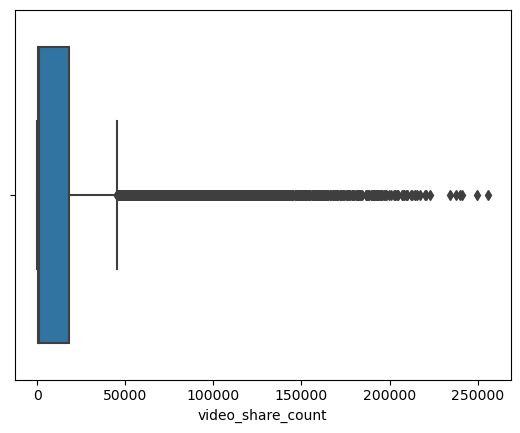

In [ ]:
# Create a boxplot to visualize distribution of `video_share_count`
sns.boxplot(x='video_share_count', data = data )

<Axes: xlabel='video_share_count', ylabel='Count'>

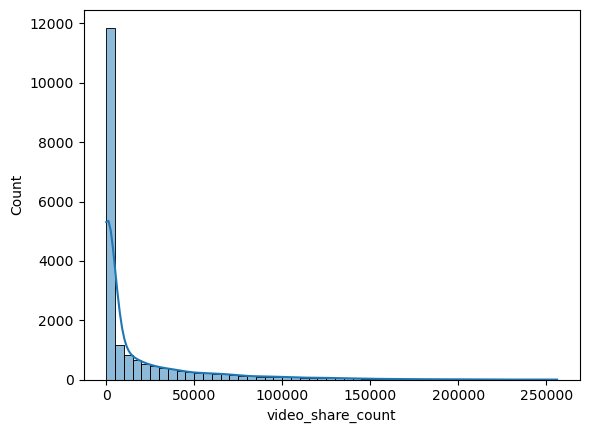

In [ ]:
# Create a histogram
sns.histplot(data=data, x='video_share_count', kde=True, bins=range(0,250001,5000))

Distribution very right-skewed. Most videos have less than 5000 shares.

#### **video_download_count**

<Axes: xlabel='video_download_count', ylabel='Count'>

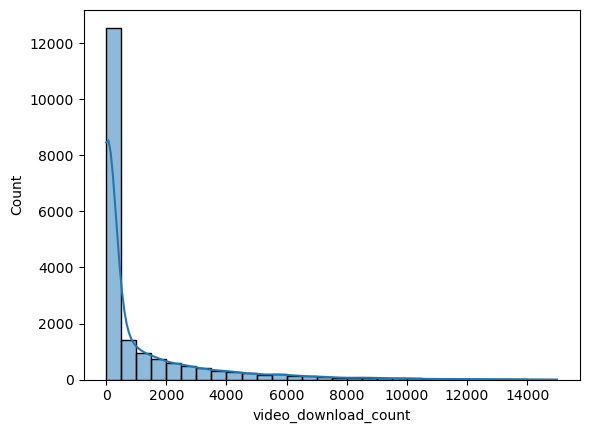

In [ ]:
sns.histplot(data=data, x='video_download_count', kde=True, bins=range(0,14001,500))

Data is very skewed to the right.Most videos were downloaded less than 500 times, but some were downloaded over 8000-14000 times.

#### **Claim status by verification status**

<Axes: xlabel='claim_status', ylabel='Count'>

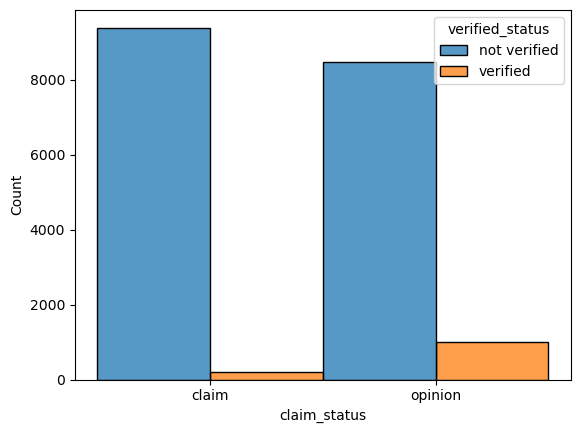

In [ ]:
### YOUR CODE HERE ###
sns.histplot(data=data, x='claim_status', hue='verified_status', multiple='dodge')

There are fewer verified users than not verified users. if a user is verified, they are more likely to post opinions.

#### **Claim status by author ban status**


<Axes: xlabel='claim_status', ylabel='Count'>

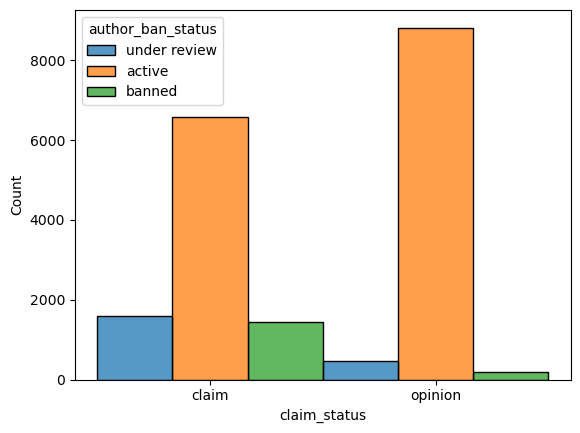

In [ ]:
sns.histplot(data=data, x='claim_status', hue='author_ban_status', multiple='dodge')

<Axes: xlabel='author_ban_status', ylabel='video_view_count'>

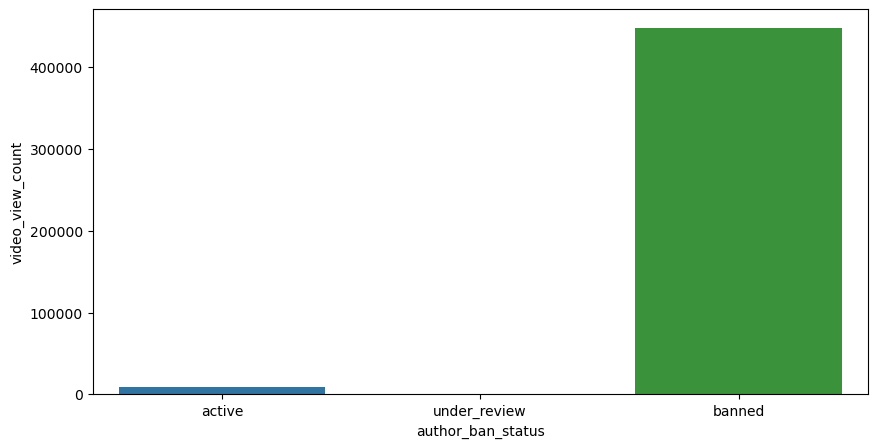

In [ ]:
#Median view counts by ban status
ban_status_count = data.groupby(['author_ban_status']).median(numeric_only=True).reset_index()

fig=plt.figure(figsize=(10,5))
sns.barplot(data=ban_status_count, x='author_ban_status', y='video_view_count', order=['active', 'under_review', 'banned'])

In [ ]:
# Calculate the median view count for claim status.
data.groupby(['claim_status'])['video_view_count'].median(numeric_only=True).reset_index()

,claim_status,video_view_count
0,claim,501555.0
1,opinion,4953.0


### Determine outliers


In [ ]:

count_col = ['video_view_count',
              'video_like_count',
              'video_share_count',
              'video_download_count',
              'video_comment_count']

for col in count_col:
    q1=data[col].quantile(0.25)
    q3=data[col].quantile(0.75)
    col_iqr = q3-q1
    col_median = data[col].median()
    col_outlier = col_median + (1.5*col_iqr)
    upper_limit= q3+(1.5*col_iqr)
    lower_limit= q1-(1.5*col_iqr)
    
    outliers = data[(data[col] > upper_limit) | (data[col]<lower_limit)]
    
    print(f'number of outliers,{col}:', len(outliers))

number of outliers,video_view_count: 0
number of outliers,video_like_count: 1726
number of outliers,video_share_count: 2508
number of outliers,video_download_count: 2450
number of outliers,video_comment_count: 2789


#### **Scatterplot**

<Axes: xlabel='video_view_count', ylabel='video_like_count'>

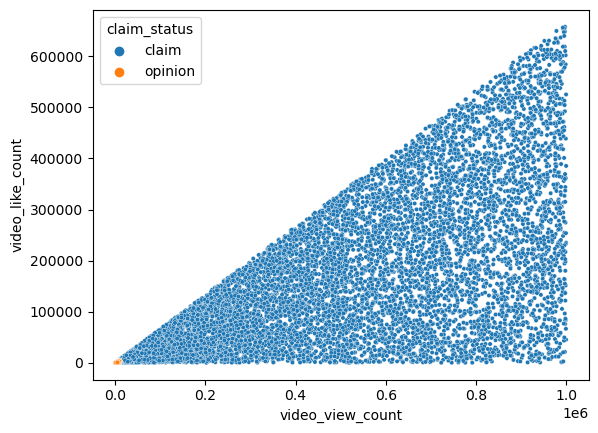

In [ ]:
# scatterplot of `video_view_count` versus `video_like_count` according to 'claim_status'
sns.scatterplot(x=data["video_view_count"], y=data["video_like_count"],
                hue=data["claim_status"], s=10)

<Axes: xlabel='video_view_count', ylabel='video_like_count'>

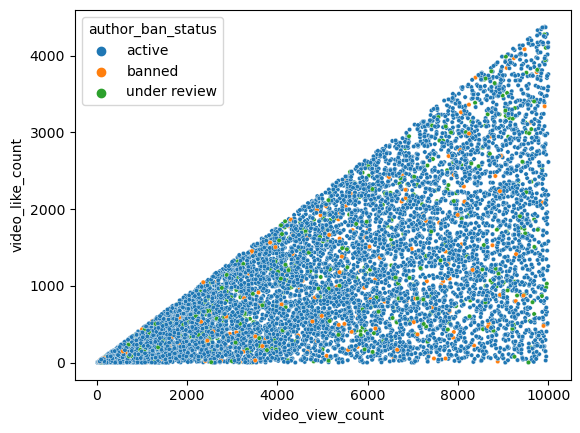

In [ ]:
# scatterplot of ``video_view_count` versus `video_like_count` for opinions only
opinion = data[data['claim_status']=='opinion']
sns.scatterplot(x=opinion["video_view_count"], y=opinion["video_like_count"], s=10, hue=opinion['author_ban_status'])

I am interested in the relationship between `verified_status` and `video_view_count`. One approach is to examine the mean values of `video_view_count` for each group of `verified_status` in the sample data.

In [ ]:
# Compute the mean `video_view_count` for each group in `verified_status`
data.groupby("verified_status")["video_view_count"].mean()

verified_status
not verified    265663.785339
verified         91439.164167
Name: video_view_count, dtype: float64

### Hypothesis testing



*   **Null hypothesis**: There is no difference in number of views between TikTok videos posted by verified accounts and TikTok videos posted by unverified accounts (any observed difference in the sample data is due to chance or sampling variability).

*    **Alternative hypothesis**: There is a difference in number of views between TikTok videos posted by verified accounts and TikTok videos posted by unverified accounts (any observed difference in the sample data is due to an actual difference in the corresponding population means).


**$H_0$**: There is no difference in number of views between TikTok videos posted by verified accounts and TikTok videos posted by unverified accounts (any observed difference in the sample data is due to chance or sampling variability).

**$H_A$**: There is a difference in number of views between TikTok videos posted by verified accounts and TikTok videos posted by unverified accounts (any observed difference in the sample data is due to an actual difference in the corresponding population means).

I chose 5% as the significance level and proceed with a two-sample t-test.

In [ ]:
# Conduct a two-sample t-test to compare means

# Save each sample in a variable
not_verified = data[data["verified_status"] == "not verified"]["video_view_count"]
verified = data[data["verified_status"] == "verified"]["video_view_count"]

# Implement a t-test using the two samples
stats.ttest_ind(a=not_verified, b=verified, equal_var=False)

Ttest_indResult(statistic=25.499441780633777, pvalue=2.6088823687177823e-120)

Since the p-value is extremely small (much smaller than the significance level of 5%), I reject the null hypothesis. I conclude that there **is** a statistically significant difference in the mean video view count between verified and unverified accounts on TikTok.


The next step will be to build a regression model on verified_status. A regression model is the natural next step because the end goal is to make predictions on claim status. A regression model for verified_status can help analyze user behavior in this group of verified users.

# Logistic Regression

During EDA, I observed that verified users are more likely to post opinions. I want to explore how video characteristics relate to verified users. Therefore,I will conduct a logistic regression using verified status as the outcome variable.

Check class balance.

In [ ]:
# Check class balance
data["verified_status"].value_counts(normalize=True)

not verified    0.93712
verified        0.06288
Name: verified_status, dtype: float64

Approximately 93.7% of the dataset represents videos posted by unverified accounts and 6.2% represents videos posted by verified accounts. So the outcome variable is not very balanced.

Use resampling to create class balance in the outcome variable

In [ ]:
# Use resampling to create class balance in the outcome variable, if needed

# Identify data points from majority and minority classes
data_majority = data[data["verified_status"] == "not verified"]
data_minority = data[data["verified_status"] == "verified"]

# Upsample the minority class (which is "verified")
data_minority_upsampled = resample(data_minority,
                                 replace=True,                 # to sample with replacement
                                 n_samples=len(data_majority), # to match majority class
                                 random_state=0)               # to create reproducible results

# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled]).reset_index(drop=True)

# Display new class counts
data_upsampled["verified_status"].value_counts()

not verified    17884
verified        17884
Name: verified_status, dtype: int64

Get the average `video_transcription_text` length for videos posted by verified accounts for claims and unverified accounts for opinions


In [ ]:
# Get the average `video_transcription_text` length for claims and the average `video_transcription_text` length for opinions
data_upsampled[["verified_status", "video_transcription_text"]].groupby(by="verified_status")[["video_transcription_text"]].agg(func=lambda array: np.mean([len(text) for text in array]))

,video_transcription_text
verified_status,
not verified,89.401141
verified,84.569559


In [ ]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe
data_upsampled["text_length"] = data_upsampled["video_transcription_text"].apply(func=lambda text: len(text))

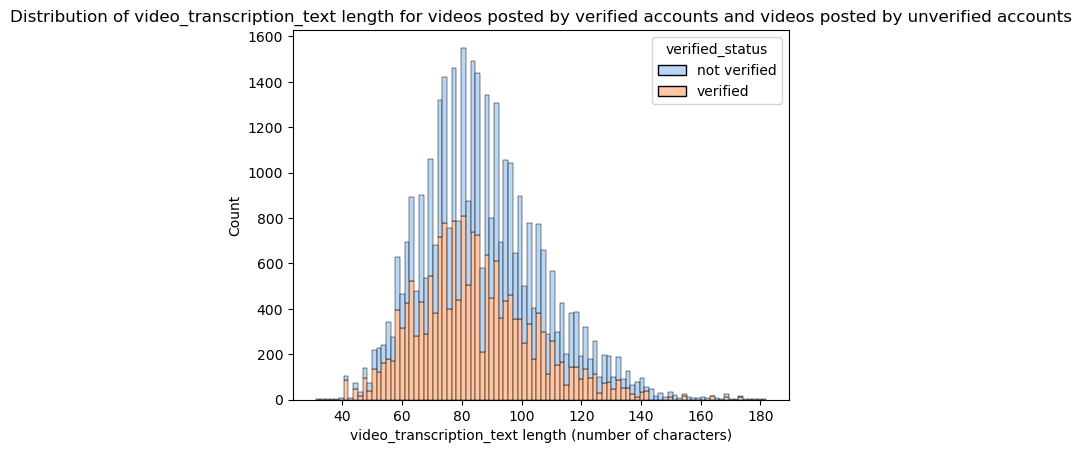

In [ ]:
# Visualize the distribution of `video_transcription_text` length for videos posted by verified accounts and videos posted by unverified accounts
# Create two histograms in one plot
sns.histplot(data=data_upsampled, stat="count", multiple="stack", x="text_length", kde=False, palette="pastel", 
             hue="verified_status", element="bars", legend=True)
plt.title("Seaborn Stacked Histogram")
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for videos posted by verified accounts and videos posted by unverified accounts")
plt.show()

Examine correlations

In [ ]:
#correlation matrix to help determine most correlated variables
data_upsampled.corr(numeric_only=True)

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length
#,1.000000,-0.000853,-0.011729,-0.697007,-0.581483,-0.504015,-0.487096,-0.413799,-0.282755,-0.311144,-0.214349,-0.193677
video_id,-0.000853,1.000000,0.011859,0.002554,0.006507,0.010515,0.008753,0.013983,-0.005539,0.005954,-0.001698,-0.007083
video_duration_sec,-0.011729,0.011859,1.000000,0.013589,0.004890,0.002206,0.003989,-0.004586,-0.003731,-0.021063,0.001244,-0.002981
video_view_count,-0.697007,0.002554,0.013589,1.000000,0.832832,0.711313,0.690048,0.583485,0.278638,0.292290,0.204884,0.244693
video_like_count,-0.581483,0.006507,0.004890,0.832832,1.000000,0.850053,0.828082,0.706140,0.571864,0.437756,0.404701,0.202386
video_share_count,-0.504015,0.010515,0.002206,0.711313,0.850053,1.000000,0.710117,0.620182,0.485643,0.389892,0.594859,0.171651
video_download_count,-0.487096,0.008753,0.003989,0.690048,0.828082,0.710117,1.000000,0.857679,0.476817,0.600509,0.343180,0.173396
video_comment_count,-0.413799,0.013983,-0.004586,0.583485,0.706140,0.620182,0.857679,1.000000,0.409255,0.748841,0.307483,0.149750
likes_per_view,-0.282755,-0.005539,-0.003731,0.278638,0.571864,0.485643,0.476817,0.409255,1.000000,0.539845,0.675187,0.094428
comments_per_view,-0.311144,0.005954,-0.021063,0.292290,0.437756,0.389892,0.600509,0.748841,0.539845,1.000000,0.394044,0.114497


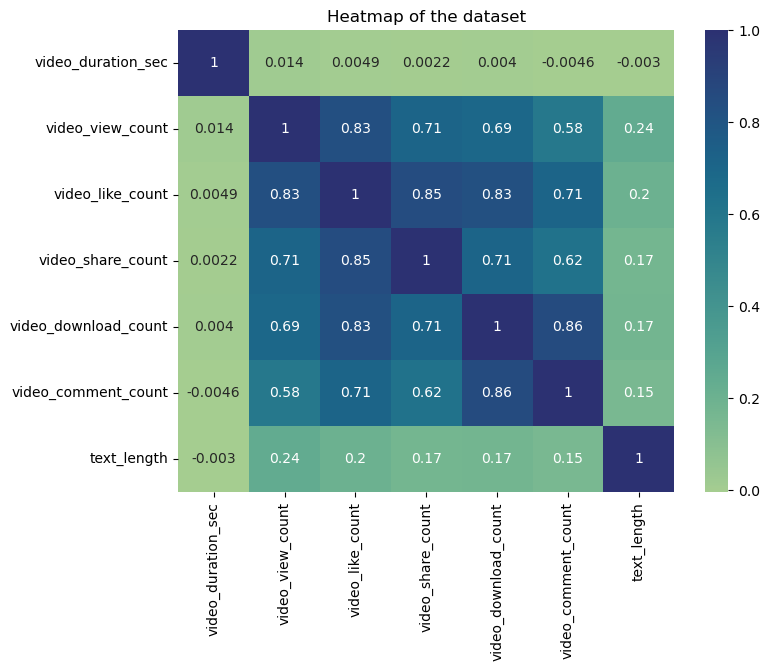

In [ ]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(
    data_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", 
                    "video_like_count", "video_share_count", "video_download_count", "video_comment_count", "text_length"]]
    .corr(numeric_only=True), 
    annot=True, 
    cmap="crest")
plt.title("Heatmap of the dataset")
plt.show()

Set your Y and X variables.

In [ ]:
# Select outcome variable
y = data_upsampled["verified_status"]

Dropping video_like_count from the model as it is highly correlated with most of the variables.

In [ ]:
X = data_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", "video_share_count", "video_download_count", "video_comment_count"]]


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [ ]:
# Get shape of each training and testing set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26826, 7), (8942, 7), (26826,), (8942,))

`claim_status` and `author_ban_status` features are each of data type `object` currently. I will need convert the categorical variables to numeric. One way to do this is through one-hot encoding.

In [ ]:
# Select the training features that needs to be encoded
X_train_to_encode = X_train[["claim_status", "author_ban_status"]]

In [ ]:
X_encoder = OneHotEncoder(drop='first', sparse_output=False)

In [ ]:
X_train_encoded = X_encoder.fit_transform(X_train_to_encode)

In [ ]:
X_encoder.get_feature_names_out()

array(['claim_status_opinion', 'author_ban_status_banned',
       'author_ban_status_under review'], dtype=object)

In [ ]:
X_train_encoded

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [ ]:
# Place encoded training features (which is currently an array) into a dataframe
X_train_encoded_df = pd.DataFrame(data=X_train_encoded, columns=X_encoder.get_feature_names_out())

# Display first few rows
X_train_encoded_df.head()

,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [ ]:
X_train.drop(columns=["claim_status", "author_ban_status"]).head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count
33058,33,2252.0,23.0,4.0,0.0
20491,52,6664.0,550.0,53.0,2.0
25583,37,6327.0,257.0,3.0,0.0
18474,57,1702.0,28.0,0.0,0.0
27312,21,3842.0,101.0,1.0,0.0


In [ ]:
# Concatenate `X_train` and `X_train_encoded_df` to form the final dataframe for training data (`X_train_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_train after dropping `claim_status` and `author_ban_status`,
# so that the indices align with those in `X_train_encoded_df` and `count_df`
X_train_final = pd.concat([X_train.drop(columns=["claim_status", "author_ban_status"]).reset_index(drop=True), X_train_encoded_df], axis=1)

# Display first few rows
X_train_final.head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,33,2252.0,23.0,4.0,0.0,1.0,0.0,0.0
1,52,6664.0,550.0,53.0,2.0,1.0,0.0,0.0
2,37,6327.0,257.0,3.0,0.0,1.0,0.0,0.0
3,57,1702.0,28.0,0.0,0.0,1.0,0.0,0.0
4,21,3842.0,101.0,1.0,0.0,1.0,0.0,0.0


In [ ]:
y_train.dtype

dtype('O')

Encode categorical values of the outcome variable the training set using an appropriate method.

In [ ]:
# Set up an encoder for one-hot encoding the categorical outcome variable
y_encoder = OneHotEncoder(drop='first', sparse_output=False)

In [ ]:
# Encode the training outcome variable
# Notes:
#   - Adjusting the shape of `y_train` before passing into `.fit_transform()`, since it takes in 2D array
#   - Using `.ravel()` to flatten the array returned by `.fit_transform()`, so that it can be used later to train the model
y_train_final = y_encoder.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# Display the encoded training outcome variable
y_train_final

array([1., 1., 1., ..., 1., 1., 0.])

# Model Building

In [ ]:
# Construct a logistic regression model and fit it to the training set
log_clf = LogisticRegression(random_state=0, max_iter=800).fit(X_train_final, y_train_final)

In [ ]:
# Select the testing features that needs to be encoded
X_test_to_encode = X_test[["claim_status", "author_ban_status"]]

# Transform the testing features using the encoder
X_test_encoded = X_encoder.transform(X_test_to_encode)


In [ ]:
# Place encoded testing features (which is currently an array) into a dataframe
X_test_encoded_df = pd.DataFrame(data=X_test_encoded, columns=X_encoder.get_feature_names_out())


In [ ]:
# Display first few rows of `X_test` with `claim_status` and `author_ban_status` columns dropped (since these features are being transformed to numeric)
X_test.drop(columns=["claim_status", "author_ban_status"]).head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count
21061,41,2118.0,57.0,5.0,2.0
31748,27,5701.0,157.0,1.0,0.0
20197,31,449767.0,75385.0,5956.0,1789.0
5727,19,792813.0,56597.0,5146.0,3413.0
11607,54,2044.0,68.0,19.0,2.0


In [ ]:
# Concatenate `X_test` and `X_test_encoded_df` to form the final dataframe for training data (`X_test_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_test after dropping `claim_status`, and `author_ban_status`,
# so that the indices align with those in `X_test_encoded_df` and `test_count_df`
X_test_final = pd.concat([X_test.drop(columns=["claim_status", "author_ban_status"]).reset_index(drop=True), X_test_encoded_df], axis=1)

# Display first few rows
X_test_final.head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,41,2118.0,57.0,5.0,2.0,1.0,0.0,0.0
1,27,5701.0,157.0,1.0,0.0,1.0,0.0,0.0
2,31,449767.0,75385.0,5956.0,1789.0,0.0,0.0,0.0
3,19,792813.0,56597.0,5146.0,3413.0,0.0,0.0,0.0
4,54,2044.0,68.0,19.0,2.0,1.0,0.0,0.0


In [ ]:
# Use the logistic regression model to get predictions on the encoded testing set
y_pred = log_clf.predict(X_test_final)

In [ ]:
y_pred

array([1., 1., 0., ..., 1., 0., 1.])

In [ ]:
# Encode the testing outcome variable
# Notes:
#   - Adjusting the shape of `y_test` before passing into `.transform()`, since it takes in 2D array
#   - Using `.ravel()` to flatten the array returned by `.transform()`, so that it can be used later to compare with predictions
y_test_final = y_encoder.transform(y_test.values.reshape(-1, 1)).ravel()

# Display the encoded testing outcome variable
y_test_final

array([1., 1., 1., ..., 0., 1., 1.])

# Visualize model results

Create a confusion matrix

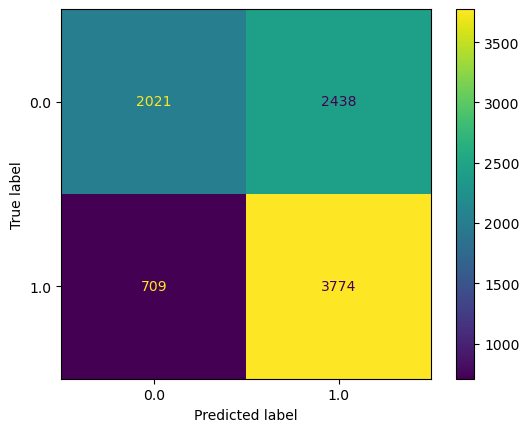

In [ ]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test_final, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()


The upper-left quadrant displays the number of true negatives: the number of videos posted by unverified accounts that the model accurately classified.

The upper-right quadrant displays the number of false positives: the number of videos posted by unverified accounts that the model misclassified as posted by verified accounts.

The lower-left quadrant displays the number of false negatives: the number of videos posted by verified accounts that the model misclassified as posted by unverified accounts.

The lower-right quadrant displays the number of true positives: the number of videos posted by verified accounts that the model accurately classified.

Create a classification report

In [ ]:
# Create classification report for logistic regression model
target_labels = ["verified", "not verified"]
print(classification_report(y_test_final, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

    verified       0.74      0.45      0.56      4459
not verified       0.61      0.84      0.71      4483

    accuracy                           0.65      8942
   macro avg       0.67      0.65      0.63      8942
weighted avg       0.67      0.65      0.63      8942



The classification report above shows that the logistic regression model achieved a precision of 61% and a recall of 84%, and it achieved an accuracy of 65%. Note that the precision and recall scores are taken from the "not verified" row of the output because that is the target class that we are most interested in predicting. The "verified" class has its own precision/recall metrics, and the weighted average represents the combined metrics for both classes of the target variable.

Interpret model coefficients

In [ ]:
# Get the feature names from the model and the model coefficients (which represent log-odds ratios)
# Place into a DataFrame for readability
pd.DataFrame(data={"Feature Name":log_clf.feature_names_in_, "Model Coefficient":log_clf.coef_[0]})

,Feature Name,Model Coefficient
0,video_duration_sec,8.493546e-03
1,video_view_count,-2.277453e-06
2,video_share_count,5.458611e-06
3,video_download_count,-2.143023e-04
4,video_comment_count,3.899371e-04
5,claim_status_opinion,3.772015e-04
6,author_ban_status_banned,-1.675961e-05
7,author_ban_status_under review,-7.084767e-07


Key takeaways:

- Based on the logistic regression model, each additional second of the video is associated with 0.009 increase in the log-odds of the user having a verified status.
- The logistic regression model had acceptable predictive power: a precision of 61% is less than ideal, but a recall of 84% is very good. Overall accuracy is towards the lower end of what would typically be considered acceptable. 


We developed a logistic regression model for verified status based on video features. The model had decent predictive power. Based on the estimated model coefficients from the logistic regression, longer videos tend to be associated with higher odds of the user being verified. Other video features have small estimated coefficients in the model, so their association with verified status seems to be small.

# Building the ML model to classify videos to predict claim status



Previous analysis indicates that when authors do violate the terms of service, they're much more likely to be presenting a claim than an opinion. Therefore, it is useful to be able to determine which videos make claims and which videos are opinions.

**Modeling design and target variable**

The target variable will be `claim_status`. This is a binary value that indicates whether a video is a claim or an opinion. The model should predict whether the video is a claim or opinion

**Evaluation metric**

  - **False positives:** When the model predicts a video is a claim when in fact it is an opinion
  - **False negatives:** When the model predicts a video is an opinion when in fact it is a claim


In this case, it is better for the model to predict false positives when it makes a mistake, and worse for it to predict false negatives. It is more important to identify videos that break the terms of service, even if some opinion videos are misclassified as claims. The worst case for an opinion misclassified as a claim is that the video goes to human review. The worst case for a claim that's misclassified as an opinion is that the video does not get reviewed and it violates the terms of service.

Because it's more important to minimize false negatives, the model evaluation metric will be **recall**.



**Modeling workflow and model selection process**

1. Split the data into train/validation/test sets (60/20/20)
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set

In [ ]:
# Check class balance
data["claim_status"].value_counts(normalize=True)

claim      0.503458
opinion    0.496542
Name: claim_status, dtype: float64

In [ ]:
# Create `text_length` column
data['text_length'] = data['video_transcription_text'].str.len()
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.004855,0.135111,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,0.108282,0.000365,0.003168,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,0.548459,0.001335,0.079569,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,0.622910,0.002706,0.073175,128


In [ ]:
#Calculate the average `text_length` for claims and opinions.

data[['claim_status', 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


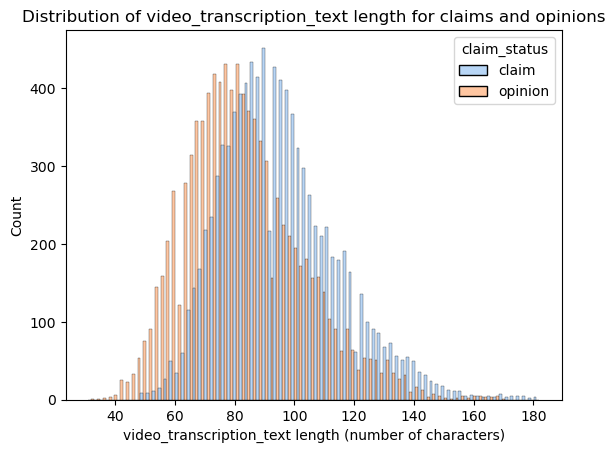

In [ ]:
# Visualize the distribution of `text_length` for claims and opinions
# Create two histograms in one plot

sns.histplot(data=data, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

**Feature selection and transformation**

In [ ]:
#encoding trget variables
X = data.copy()
# Drop unnecessary columns
X = X.drop(['#', 'video_id'], axis=1)
# Encode target variable
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})
# Dummy encode remaining categorical values
X = pd.get_dummies(X,
                   columns=['verified_status', 'author_ban_status'],
                   drop_first=True)
X.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702,97,0,0,1
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.004855,0.135111,107,0,0,0
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,0.108282,0.000365,0.003168,137,0,0,0
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,0.548459,0.001335,0.079569,131,0,0,0
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,0.622910,0.002706,0.073175,128,0,0,0


# Splitting the data
In this case, the target variable is `claim_status`.
* 0 represents an opinion
* 1 represents a claim

In [ ]:
# Isolate target variable
y = X['claim_status']

In [ ]:
X = X.drop(['claim_status'], axis=1)

# Display first few rows of features dataframe
X.head()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702,97,0,0,1
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.004855,0.135111,107,0,0,0
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,0.108282,0.000365,0.003168,137,0,0,0
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,0.548459,0.001335,0.079569,131,0,0,0
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,0.622910,0.002706,0.073175,128,0,0,0


In [ ]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

In [ ]:
# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 14), (3817, 14), (3817, 14), (11450,), (3817,), (3817,))

### Tokenize text column


The feature `video_transcription_text` is text-based. It is not a categorical variable, since it does not have a fixed number of possible values. One way to extract numerical features from it is through a bag-of-words algorithm like [`CountVectorizer`]

In [ ]:
# Set up a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [ ]:
# Extract numerical features from `video_transcription_text` in the training set
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [ ]:
# Place the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

# Display first few rows
count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Concatenate `X_train` and `count_df` to form the final dataframe for training data (`X_train_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_train after dropping `video_transcription_text`,
# so that the indices align with those in `X_train` and `count_df`
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

# Display first few rows
X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,51,2487.0,310.0,20.0,1.0,0.0,0.124648,0.000000,0.008042,134,...,0,0,0,0,0,0,0,0,0,0
1,43,118512.0,3543.0,374.0,70.0,29.0,0.029896,0.000245,0.003156,97,...,0,1,0,0,0,0,0,0,0,0
2,22,105902.0,1885.0,229.0,39.0,9.0,0.017799,0.000085,0.002162,76,...,0,1,0,0,0,0,0,0,0,0
3,17,9245.0,1670.0,440.0,13.0,4.0,0.180638,0.000433,0.047593,58,...,0,0,0,0,0,0,0,0,0,0
4,18,3791.0,660.0,63.0,9.0,1.0,0.174097,0.000264,0.016618,57,...,0,0,0,0,0,0,0,0,0,0


Get n-gram counts for the validation data. Notice that the vectorizer is not being refit to the validation data. It's only transforming it. In other words, the transcriptions of the videos in the validation data are only being checked against the n-grams found in the training data.

In [ ]:
# Extract numerical features from `video_transcription_text` in the testing set
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [ ]:
# Place the numerical representation of `video_transcription_text` from validation set into a dataframe
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())

# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_val after dropping `video_transcription_text`,
# so that the indices align with those in `validation_count_df`
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)

# Display first few rows
X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,578891.0,379596.0,14612.0,6591.0,44.0,0.655730,0.000076,0.025241,72,...,0,0,0,0,0,0,0,1,0,0
1,24,6255.0,1709.0,311.0,13.0,1.0,0.273221,0.000160,0.049720,96,...,0,0,0,0,0,0,0,0,0,0
2,35,410356.0,249714.0,26235.0,2060.0,1252.0,0.608530,0.003051,0.063932,88,...,0,1,0,0,0,0,0,1,0,0
3,58,406911.0,25986.0,1230.0,564.0,248.0,0.063862,0.000609,0.003023,83,...,0,0,0,0,0,0,0,0,0,0
4,47,972573.0,138167.0,25320.0,3331.0,968.0,0.142063,0.000995,0.026034,104,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Extract numerical features from `video_transcription_text` in the testing set
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` from test set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.0,16591.0,622.0,312.0,0.196444,0.000451,0.023973,107,...,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.0,36.0,17.0,1.0,0.359799,0.000194,0.006971,69,...,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,344163.0,57608.0,8578.0,2942.0,0.429157,0.003669,0.071835,90,...,0,0,0,0,0,0,0,0,0,0
3,44,6429.0,2314.0,847.0,17.0,5.0,0.359932,0.000778,0.131747,76,...,0,0,0,0,0,0,0,0,0,0
4,26,555780.0,106863.0,15348.0,252.0,91.0,0.192276,0.000164,0.027615,72,...,0,0,0,0,0,0,0,0,0,0


### **Build a random forest model**


In [ ]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [ ]:
%%time
rf_cv.fit(X_train_final, y_train)

CPU times: total: 13min 28s
Wall time: 13min 50s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring={'recall', 'precision', 'f1', 'accuracy'})

In [ ]:
# Examine best recall score
rf_cv.best_score_

0.9958582006702817

In [ ]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}


This model performs exceptionally well, with an average recall score of 0.995 across the five cross-validation folds. After checking the precision score to be sure the model is not classifying all samples as claims, it is clear that this model is making almost perfect classifications.

# Build an XGBoost model

In [ ]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [ ]:
%%time
xgb_cv.fit(X_train_final, y_train)

CPU times: total: 38min 34s
Wall time: 2min 42s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring={'recall', 'precision', 'f1', 'accuracy'})

In [ ]:
xgb_cv.best_score_

0.9925792141101926

In [ ]:
xgb_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 300}

This model also performs exceptionally well. Although its recall score is very slightly lower than the random forest model's, its precision score is perfect.

# Model Evaluation

In [ ]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(X_val_final)

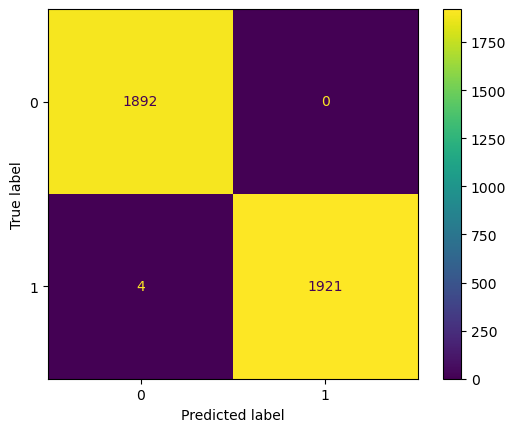

In [ ]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

In [ ]:
# Create a classification report
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



The classification report above shows that the random forest model scores were nearly perfect. The confusion matrix indicates that there were 4 misclassifications : 4 false negatives.

Evaluate the XGBoost model on the validation set.

In [ ]:
#Evaluate XGBoost model
y_pred = xgb_cv.best_estimator_.predict(X_val_final)

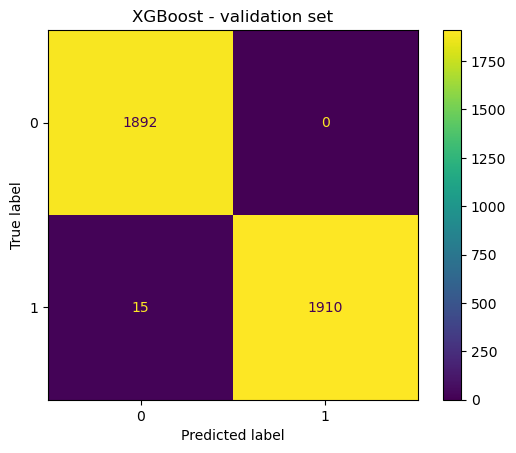

In [ ]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set');
plt.show()

In [ ]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      1.00      1892
       claim       1.00      0.99      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



The results of the XGBoost model were also nearly perfect. However, it had more false ngeatives. Identifying claims was the priority, so it's important that the model be good at capturing all actual claim videos. The random forest model has a better recall score, and is therefore the champion model.

### **Use champion model to predict on test data**

Both random forest and XGBoost model  resulted in nearly perfect models. Nonetheless, in this case random forest performed a little bit better, so it is the champion model.

In [ ]:
# Use champion model to predict on test data
y_pred = rf_cv.best_estimator_.predict(X_test_final)

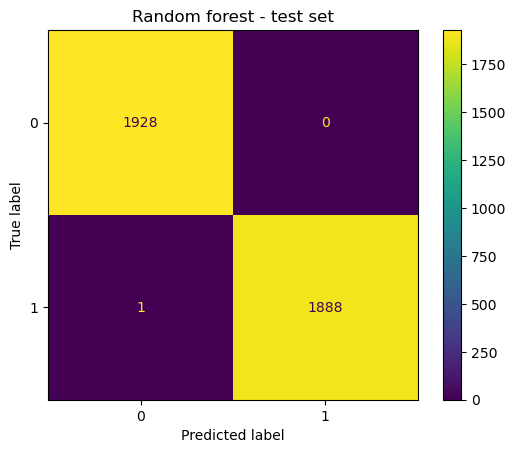

In [ ]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('Random forest - test set')
plt.show()

Feature Importances

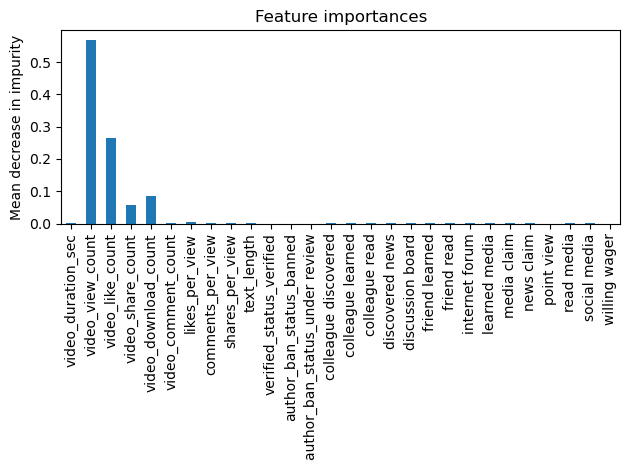

In [ ]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

The most predictive features all were related to engagement levels generated by the video. This is the same conclusion as the analysis from prior EDA as well.

# Conclusion
The model performed well on both the validation and test data. Furthermore, both precision and F1 scores were consistently high. The model was able to classify claims and opinions almost perfectly.

The model's most predictive features were all related to the user engagement levels associated with each video. It was classifying videos based on how many views, likes, shares, and downloads they received.

The current version of the model does not need any new features. However, it would be helpful to have the number of times the video was reported. It would also be useful to have the total number of user reports for all videos posted by each author.